In [ ]:
# standard data tools
import numpy as np
import pandas as pd

# common visualizing tools
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as colors
import matplotlib as mpl

# CNN layers and the Deep Learning model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Input
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense , Flatten, Dropout
from keras.activations import *

# splitting tool for the validation set
from sklearn.model_selection import train_test_split

# for loading the dataset 
import torch
from torch.utils.data import DataLoader, Dataset

# to block unnecesarry warnings for updates etc.
import warnings
warnings.filterwarnings("ignore")

In [ ]:
#Imports for Scikit Optimizer
import skopt
from skopt import gp_minimize, forest_minimize
from skopt.space import Real, Categorical, Integer
from skopt.plots import plot_convergence
from skopt.plots import plot_objective, plot_evaluations
from skopt.plots import plot_objective
from skopt.utils import use_named_args

# Loading the Sign Language Digits datasets

In [ ]:
# Make sure the data is uploaded to your google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
class SignLanguageDataSet(Dataset):
    """ sign language dataset"""

    def __init__(self, X, Y, onehot=True):
        """
        :param X: numpy.array
        :param Y: numpy.array
        """
        X = X.reshape((-1, 1, 64, 64))  # we need to add a channel, so we can use convolution
        if onehot:  # the Y from npy is onehot-encoded, need to convert to interger
            Y = np.argmax(Y, axis=1)

        self.X = torch.from_numpy(X)
        self.Y = torch.from_numpy(Y)

    def __len__(self):
        return len(self.Y)

    def __getitem__(self, idx):
        X = self.X[idx]
        Y = self.Y[idx]
        return X, Y

input_size  = 64*64   # images are 64x64 pixels
output_size = 10      # there are 10 classes

X = np.load("/content/gdrive/My Drive/X.npy")
Y = np.load("/content/gdrive/My Drive/Y.npy")

The Sign Language Digits Dataset contains 2062 64×64 pixel images of the digits 0 to 9 represented using sign language. 

# Data Split into train and test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)

# Hyper-Parameters

We try to find the optimized values for the several hyper-parameters required in the deep learning model to classify the dataset.

In [ ]:
# Learning Rate
dim_learning_rate = Real(low=1e-4, high=9e-1, prior='log-uniform',
                         name='learning_rate')

# Activation Function
dim_activation = Categorical(categories=["relu", "sigmoid"],
                             name='activation')
# Regularisation Function
dim_regularisation = Real(low=0, high=0.5, prior='uniform',
                         name='drop_rate')

# Number of Dense layers and the number of nodes in each layer
dim_filter_1 = Categorical(categories=[4, 8, 16, 32, 64, 128, 256], name='num_filter_1')
dim_kernel_1 = Categorical(categories=[1, 2, 3 , 4, 5, 6, 7], name='num_kernel_1')

dim_filter_2 = Categorical(categories=[4, 8, 16, 32, 64, 128, 256], name='num_filter_2')
dim_kernel_2 = Categorical(categories=[1, 2, 3 , 4, 5, 6, 7], name='num_kernel_2')

dim_filter_3 = Categorical(categories=[4, 8, 16, 32, 64, 128, 256], name='num_filter_3')
dim_kernel_3 = Categorical(categories=[1, 2, 3 , 4, 5, 6, 7], name='num_kernel_3')

dim_kernel_4 = Categorical(categories=[1, 2, 3 , 4, 5, 6, 7], name='num_kernel_4')

dim_dense_1 = Categorical(categories=[4, 8, 16, 32, 40, 64, 128, 256, 512], name='num_dense_1')
dim_dense_2 = Categorical(categories=[4, 8, 16, 32, 40, 64, 128, 256, 512], name='num_dense_2')
dim_dense_3 = Categorical(categories=[4, 8, 16, 32, 64, 40, 128, 256, 512], name='num_dense_3')

#Keeping all the search dimensions into a single list
dimensions = [dim_learning_rate,
              dim_activation,
              dim_regularisation,
              dim_filter_1,
              dim_kernel_1,
              dim_filter_2,
              dim_kernel_2,
              dim_filter_3,
              dim_kernel_3,
              dim_kernel_4,
              dim_dense_1,
              dim_dense_2,
              dim_dense_3]

#setting up the default parameters
default_parameters = [0.0002, 'relu', 0.2, 16, 5, 32, 4, 64, 3, 2, 128, 64, 40]

In [ ]:
# This is a function to log traning progress so that can be viewed by TnesorBoard.
def log_dir_name(learning_rate, num_dense_layers,
                   num_dense_nodes, activation, drop_rate, num_filter, num_kernel):

    # The dir-name for the TensorBoard log-dir.
    s = "./19_logs/lr_{0:.0e}_layers_{1}_nodes_{2}_{3}/drop_out_{4}/num_filter_{5}/num_kernel_{6}/"

    # Insert all the hyper-parameters in the dir-name.
    log_dir = s.format(learning_rate,
                       num_dense_layers,
                       num_dense_nodes,
                       activation,
                       drop_rate,
                       num_filter,
                       num_kernel)

    return log_dir

Giving the path for the best model saved in the disk containing the optimized hyper parameters.

In [ ]:
path_best_model = '19_best_model.h5'
best_accuracy = 0.0
validation_data = (X_test, y_test)

# Hyper Parameter Optimization

## Creating the model

We design a sequential model by adding the data dimensions, number of layers, activation function, learning rate, etc.

In [ ]:
def create_model(learning_rate, activation, drop_rate, num_filter_1, num_kernel_1,num_filter_2, num_kernel_2, num_filter_3, num_kernel_3, num_kernel_4, num_dense_1, num_dense_2, num_dense_3):
  CNN_model = Sequential()

  # adding model layers
  CNN_model.add(Conv2D(filters=num_filter_1, kernel_size=(num_kernel_1, num_kernel_1),activation=activation,padding="same",input_shape=(64,64,1)))
  CNN_model.add(Conv2D(filters=num_filter_2, kernel_size=(num_kernel_1, num_kernel_1),activation=activation,padding="same"))
  CNN_model.add(MaxPooling2D(pool_size=(2, 2)))

  CNN_model.add(Conv2D(filters = num_filter_2, kernel_size=(num_kernel_2, num_kernel_2),activation = activation, padding="same"))
  CNN_model.add(Conv2D(filters = num_filter_2 ,kernel_size=(num_kernel_2, num_kernel_2),activation= activation,padding="same"))
  CNN_model.add(MaxPooling2D(pool_size=(2, 2)))

  CNN_model.add(Dropout(drop_rate))

  CNN_model.add(Conv2D(filters=num_filter_2,kernel_size = (num_kernel_3, num_kernel_3), activation= activation,padding="same"))
  CNN_model.add(Conv2D(filters=num_filter_3,kernel_size=(num_kernel_3, num_kernel_3), activation = activation,padding="same"))
  CNN_model.add(MaxPooling2D(pool_size=(2, 2)))

  CNN_model.add(Dropout(drop_rate))

  CNN_model.add(Conv2D(filters=num_filter_2,kernel_size=(num_kernel_4, num_kernel_4), activation = activation,padding="same"))
  CNN_model.add(MaxPooling2D(pool_size=(2, 2)))

  CNN_model.add(Dropout(drop_rate))

  CNN_model.add(Flatten())

  # adding dense layer
  CNN_model.add(Dense(num_dense_1,activation="relu"))
  CNN_model.add(Dense(num_dense_2,activation="relu"))
  CNN_model.add(Dense(num_dense_3,activation="relu"))

  # using softmax-activation for classification.
  CNN_model.add(Dense(10,activation="softmax"))

  # using the Adam method for training the network.
  optimize = Adam(lr=learning_rate)

  # compiling the model so it can be trained
  CNN_model.compile(optimizer=optimize,loss=keras.losses.categorical_crossentropy,metrics=["accuracy"]) # using 'categorical_crossentropy' as loss function for classification problem  
  return CNN_model

The below function is used to create and train a network with given hyper-parameters and then evaluating the model performance with the validation dataset. 

In [ ]:
@use_named_args(dimensions=dimensions)
def fitness(learning_rate, activation, drop_rate, num_filter_1, num_kernel_1,num_filter_2, num_kernel_2, num_filter_3, num_kernel_3, num_kernel_4, num_dense_1, num_dense_2, num_dense_3):
    # Printing the hyper-parameters.
    print('learning rate: {0:.1e}'.format(learning_rate))
    print('activation:', activation)
    print('drop out rate:', drop_rate)
    print('num_filter_1:', num_filter_1)
    print('num_kernel_1:', num_kernel_1)
    print('num_filter_2:', num_filter_2)
    print('num_kernel_2:', num_kernel_2)
    print('num_filter_3:', num_filter_3)
    print('num_kernel_3:', num_kernel_3)
    print('num_kernel_4:', num_kernel_4)
    print('num_dense_1:', num_dense_1)
    print('num_dense_2:', num_dense_2)
    print('num_dense_3:', num_dense_3)

    print()
    
    # Creating the neural network architecture with these hyper-parameters.
    model = create_model(learning_rate,
                         activation,
                         drop_rate,
                         num_filter_1, num_kernel_1,num_filter_2, num_kernel_2, num_filter_3, num_kernel_3, num_kernel_4, num_dense_1, num_dense_2, num_dense_3)
    print(model.summary())
   
    # Using Keras to train the model.
    history = model.fit(x= X_train,
                        y= y_train,
                        epochs=70,
                        batch_size=128,
                        validation_data=validation_data)

    # Getting the classification accuracy on the validation-set after the last training-epoch.
    accuracy = history.history['val_accuracy'][-1]

    # Printing the classification accuracy.
    print()
    print("Accuracy: {0:.2%}".format(accuracy))
    print()

    # Saving the model if it improves on the best-found performance.
    # We use the global keyword so we update the variable outside of this function.
    global best_accuracy

    # If the classification accuracy of the saved model is improved ...
    if accuracy > best_accuracy:
        # Saving the new model to harddisk.
        model.save(path_best_model)
        
        # We update the classification accuracy.
        best_accuracy = accuracy

    # We delete the Keras model with these hyper-parameters from memory.
    del model
    
    # It is important to clear the Keras session, else it will keep adding new models each time to the same TensorFlow graph when we create  a model with a different set of hyper-parameters.
    K.clear_session()
    
    return -accuracy

Scikit-optimize(skopt) does minimization instead of maximization so it tries to find a set of hyper-parameters with the LOWEST fitness-value. But we are interested in the HIGHEST classification accuracy, so we need to negate this number so it can be maximized.

### Testing the model with dafault parameters

In [ ]:
%%time
fitness(x = default_parameters)

learning rate: 2.0e-04
activation: relu
drop out rate: 0.2
num_filter_1: 16
num_kernel_1: 5
num_filter_2: 32
num_kernel_2: 4
num_filter_3: 64
num_kernel_3: 3
num_kernel_4: 2
num_dense_1: 128
num_dense_2: 64
num_dense_3: 40

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 16)        416       
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        12832     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        16416     
                                                                 
 conv2d_3 (Conv2D)           (

-0.9709442853927612

We can observe that the accuracy of the model is 97.09% from the default hyper-parameter performance.

# Bayesian Optimization

Now we try to examine Bayesian optimization from schikit-optimize(skopt) library. Although the fitness function is an expensive operation we are using 40 runs for it.

In [ ]:
%%time
search_result = gp_minimize(func=fitness,
                            dimensions=dimensions,
                            acq_func='EI', # Expected Improvement.
                            n_calls=40,
                            x0=default_parameters)

Streaming output truncated to the last 5000 lines.
 conv2d (Conv2D)             (None, 64, 64, 128)       3328      
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 16)        51216     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 16)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 16)        1040      
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 16)        1040      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 16)       0         
 2D)                                                             
                                                                 
 dropout (Dropout)       

# Progress visualization

We use plot_convergence function of skopt, to visualize the optimization progress and the best fitness value from the y-axis.

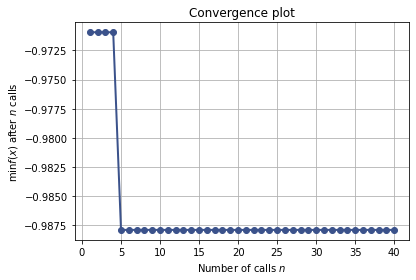

In [ ]:
plot_convergence(search_result) 

## Optimal Hyper-Parameters

We are using serach_result function to find the best hyper-parameters that Bayesian-opitimzer generated.

In [ ]:
search_result.x

[0.00030466663553174397,
 'relu',
 0.3126807547863481,
 32,
 3,
 32,
 4,
 128,
 5,
 4,
 16,
 64,
 32]

In [ ]:
search_result.fun

-0.9878934621810913

This is the best fitness value associated with the optimized hyper parameters.

## Plots

Here, we have the 2D plots of the optimized hyper parameters taken two at a time. The plots are subject to change in each run of optimization because of random noise and training process in the Neural Network architecture.

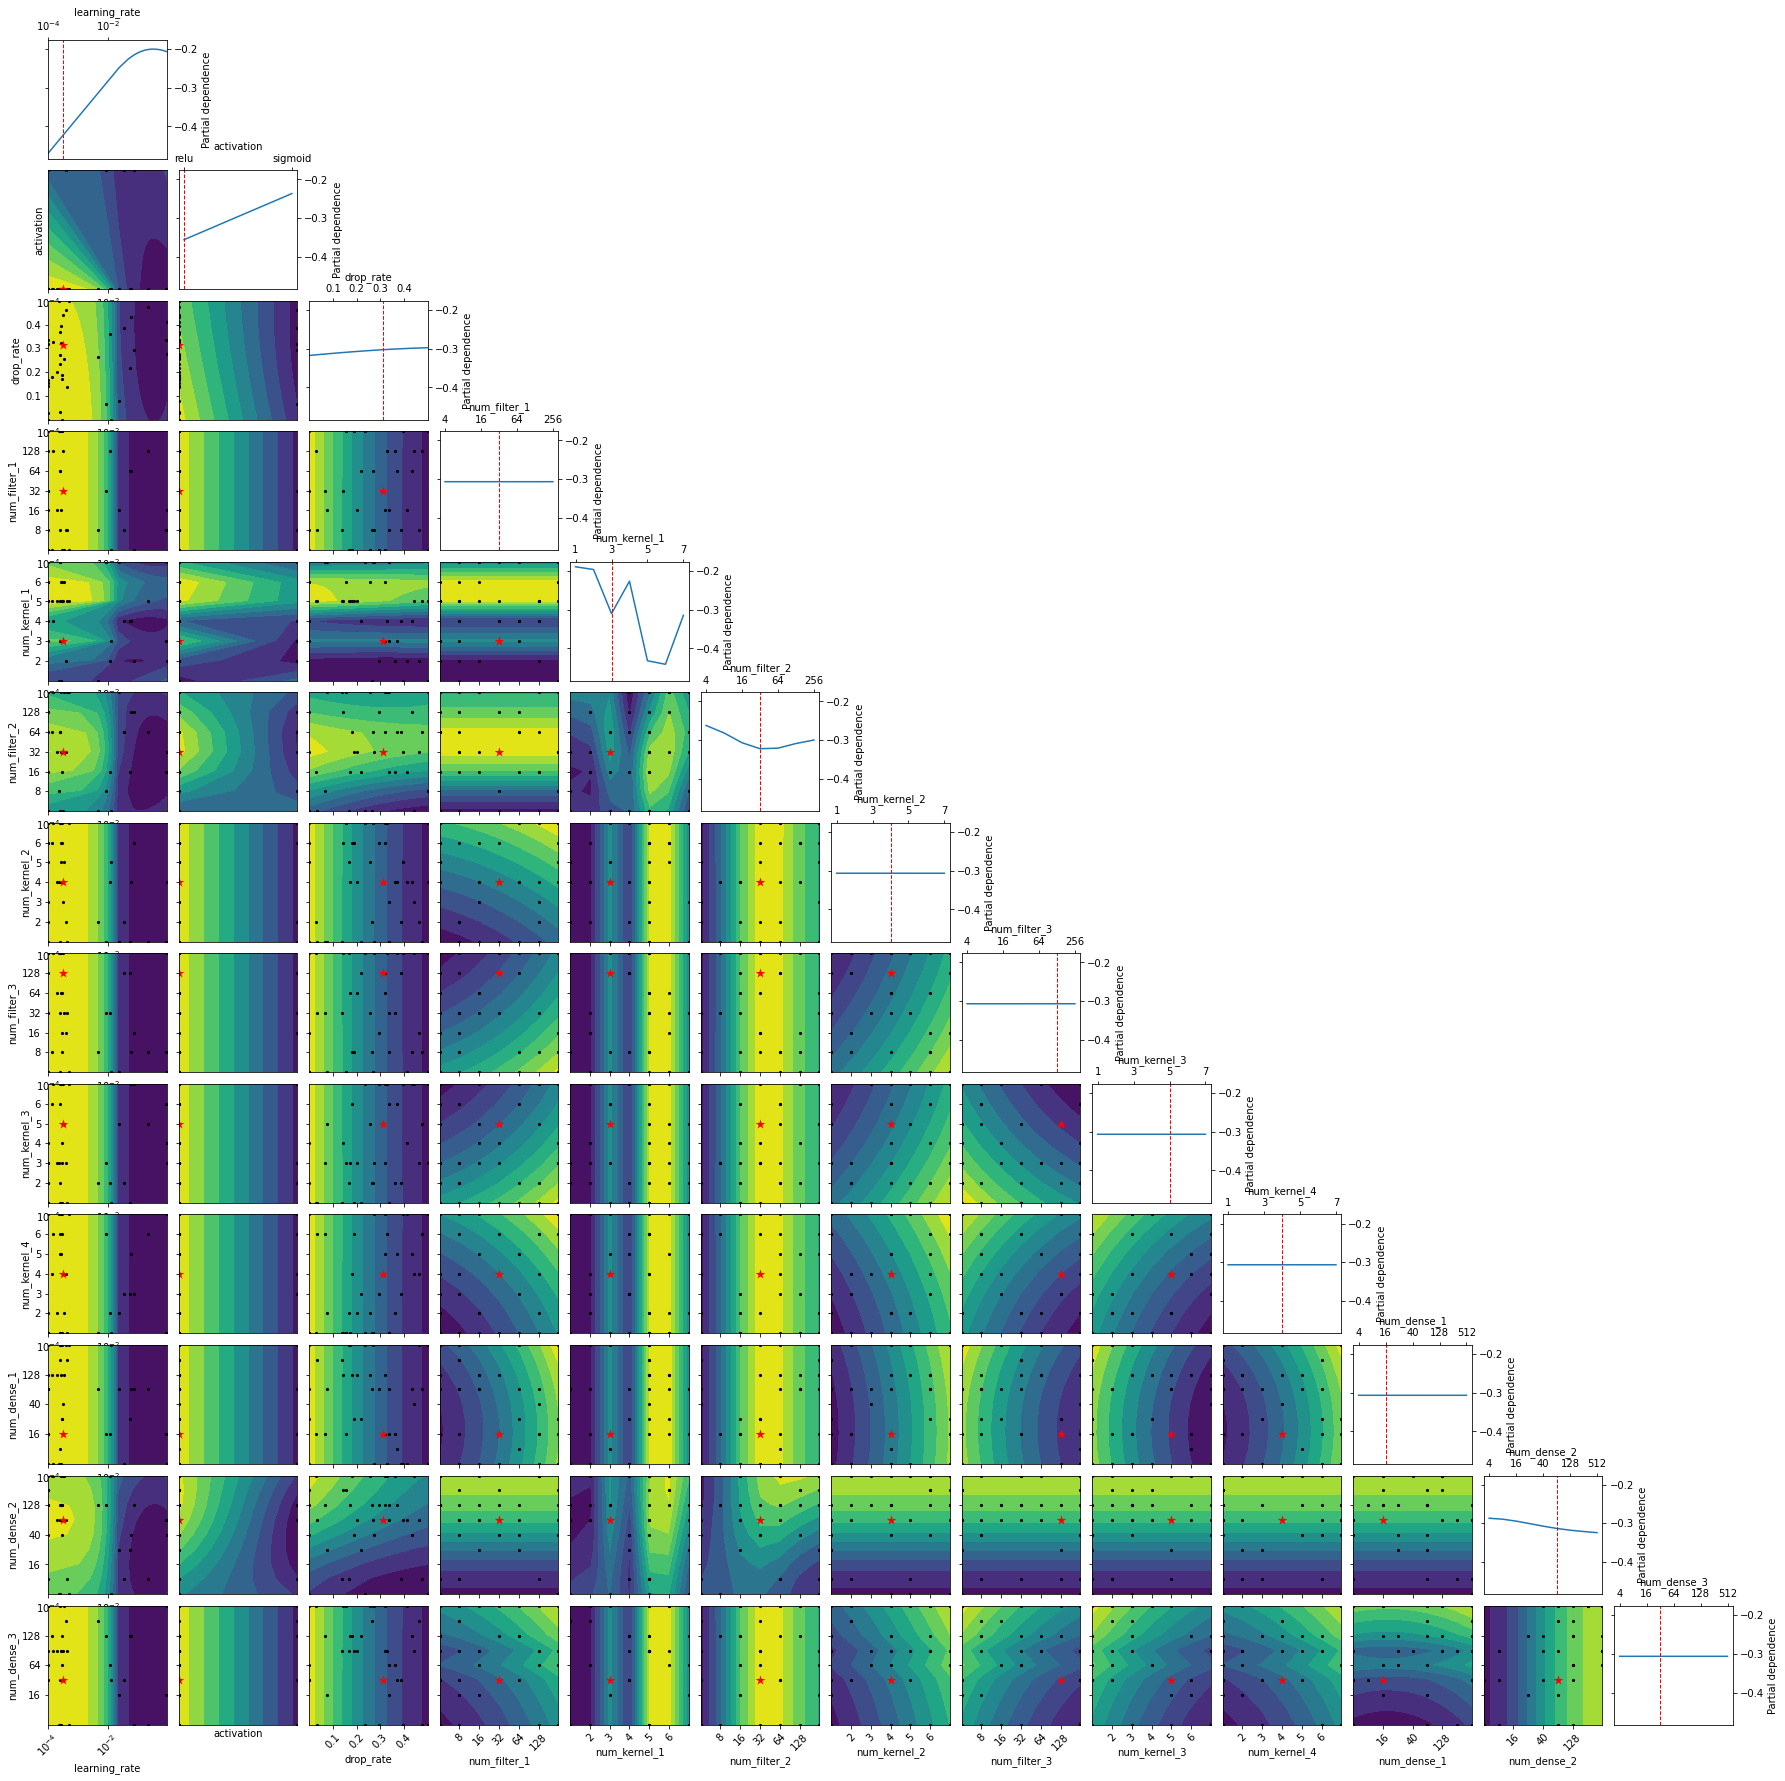

In [ ]:
dim_names = ['learning_rate', 'activation', 'drop_rate', 'num_filter_1', 'num_kernel_1','num_filter_2', 'num_kernel_2', 'num_filter_3', 'num_kernel_3', 'num_kernel_4','num_dense_1','num_dense_2', 'num_dense_3']
fig = plot_objective(result=search_result, dimensions=dim_names)

# Getting the best model from Bayesian Optimization

In [ ]:
best_model= load_model(path_best_model)

# Evaluating the model with optimized hyper-parameters on test data

### Storing the optimized hyper parameters

In [ ]:
opt_par = search_result.x

In [ ]:
# using the hyper-parameters from optimization
learning_rate = opt_par[0]
activation = opt_par[1]
drop_rate = opt_par[2]
num_filter_1 = opt_par[3]
num_kernel_1 = opt_par[4]
num_filter_2 = opt_par[5] 
num_kernel_2 = opt_par[6]
num_filter_3 = opt_par[7] 
num_kernel_3 = opt_par[8]
num_kernel_4 = opt_par[9] 
num_dense_1 = opt_par[10]
num_dense_2 = opt_par[11] 
num_dense_3 = opt_par[12]

### Creating the neural network architecture with the optimized hyper-parameters

In [ ]:
opt_model = create_model(learning_rate,
                         activation,
                         drop_rate,
                         num_filter_1, num_kernel_1,num_filter_2, num_kernel_2, num_filter_3, num_kernel_3, num_kernel_4, num_dense_1, num_dense_2, num_dense_3)
print(opt_model.summary())

# Training the model.
results = opt_model.fit(x= X_train,
                        y= y_train,
                        epochs=70,
                        batch_size=128,
                        validation_data=validation_data)

# Getting the classification accuracy on the validation-set after the last training-epoch.
accuracy = results.history['val_accuracy'][-1]

# Printing the classification accuracy.
print()
print("Accuracy: {0:.2%}".format(accuracy))
print()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 64, 64, 32)        320       
                                                                 
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        16416     
                                                                 
 conv2d_8 (Conv2D)           (None, 32, 32, 32)        16416     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                  

The acuracy achieved on the Neural Network architecture using the optimized hyper-parameters from Bayesian Optimization is 98.06%.

# Plotting the loss and accuracy

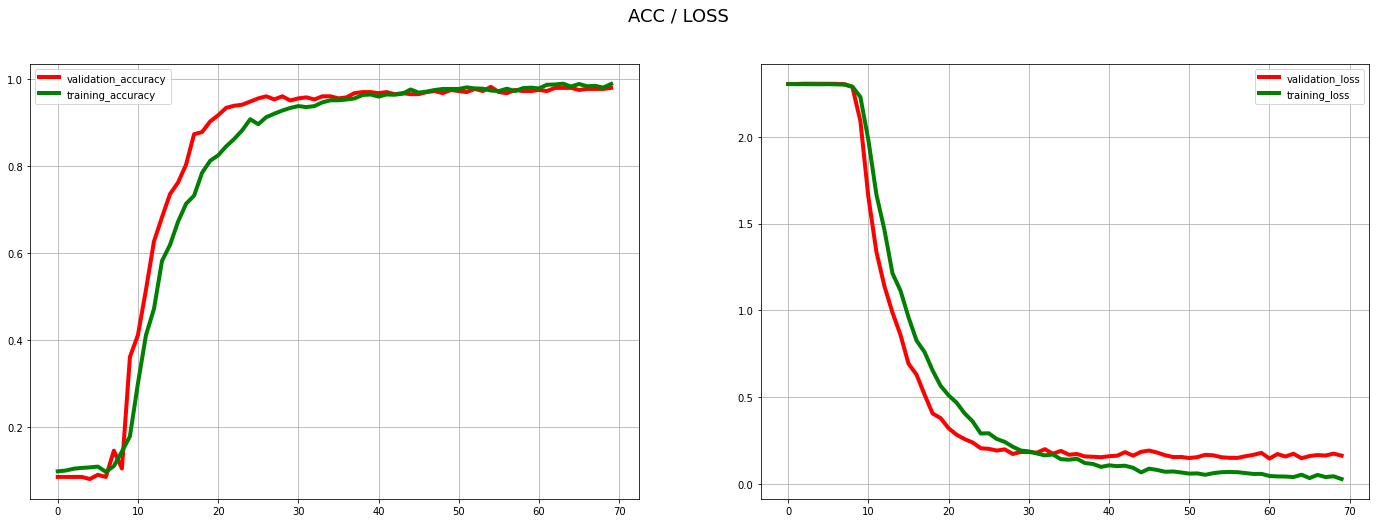

In [ ]:
plt.figure(figsize=(24,8))

plt.subplot(1,2,1)
plt.plot(results.history["val_accuracy"],label="validation_accuracy",c="red",linewidth=4)
plt.plot(results.history["accuracy"],label="training_accuracy",c="green",linewidth=4)
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(results.history["val_loss"],label="validation_loss",c="red",linewidth=4)
plt.plot(results.history["loss"],label="training_loss",c="green",linewidth=4)
plt.legend()
plt.grid(True)

plt.suptitle("ACC / LOSS",fontsize=18)

plt.show()

The accuracy and loss achieved on both training and test data are really close to each other when we use the optimized hyper parameters in the neural network architecture.